This is statregistration.py but then for multiple .nlp's. Edited from Tobias' script:

    Calculates shifts from CPcorrected and create a shift corrected stack. The calculations implements the drift
    correction algorithm as described in section 4 of the paper.
    https://doi.org/10.1016/j.ultramic.2019.112913
    https://github.com/TAdeJong/LEEM-analysis/blob/master/2%20-%20Driftcorrection.ipynb

    It uses cross correlation of all pairs of
    images after applying digital smoothing and edge detection filters to align
    Low Energy Electron Microscopy images with each other. When applied correctly,
    this allows for sub-pixel accurate image registration.

    Config parameters:
        SAVEFIG, boolean whether to save the figures
        stride: A stride larger than 1 takes 1 every stride images of the total dataset, This decreases computation time
            by a factor of stride**2, but decreases accuracy
        blocksize: dE is the blocksize used by dask, the number of images computed for at once.
        fftsize: The size of the image for which the drift correction is calculated
        startI: Starting frame for which the drift correction is calculated
        endI: Ending frame for which the drift correction is calculated
        sigma: the gaussian width over which the images are smoothened

Added napari to choose a rectangular patch on which to perform drift correction.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da
from dask.distributed import Client, LocalCluster
import scipy.ndimage as ndi

import os
import time

import napari 
%gui qt

from pyL5.lib.analysis.container import Container
from pyL5.analysis.CorrectChannelPlate.CorrectChannelPlate import CorrectChannelPlate
import pyL5.lib.analysis.Registration as Reg

cluster = LocalCluster(n_workers=1, threads_per_worker=6)
client = Client(cluster)
client

C:\Users\wgstam\Anaconda3\envs\pyL5\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62459 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:62459/status,
Dashboard: http://127.0.0.1:62459/status,Workers: 1
Total threads: 6,Total memory: 19.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62460,Workers: 1
Dashboard: http://127.0.0.1:62459/status,Total threads: 6
Started: Just now,Total memory: 19.87 GiB
Comm: tcp://127.0.0.1:62474,Total threads: 6
Dashboard: http://127.0.0.1:62475/status,Memory: 19.87 GiB
Nanny: tcp://127.0.0.1:62463,


In [34]:
def plot_masking(DX_DY, W_n, coords, dx, dy, shifts, min_normed_weight, sigma):
    """Plot W, DX and DY to pick a value for W_{min} (Step 7 of algorithm)"""
    extent = [startI, endI, endI, startI]
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True)
    im = {}
    im[0] = axs[0].imshow(DX_DY[0], cmap='seismic', extent=extent, interpolation='none')
    im[1] = axs[1].imshow(DX_DY[1], cmap='seismic', extent=extent, interpolation='none')
    im[2] = axs[2].imshow(W_n - np.diag(np.diag(W_n)), cmap='inferno',
                          extent=extent, clim=(0.0, None), interpolation='none')
    axs[3].plot(coords, dx, 'x', label='dx')
    axs[3].plot(coords, dy, 'x', label='dy')
    axs[3].plot(shifts[:, 0], color='C0')
    axs[3].plot(shifts[:, 1], color='C1')
    axs[3].set_xlabel('frames')
    axs[3].set_ylabel('shift (pixels)')
    axs[3].set_box_aspect(1)
    axs[3].legend()
    
    axs[0].set_ylabel('$j$')
    fig.colorbar(im[0], ax=axs[:2], shrink=0.82, fraction=0.1)
    axs[0].contourf(W_n, [0, min_normed_weight], colors='black', alpha=0.6, extent=extent, origin='upper')
    axs[1].contourf(W_n, [0, min_normed_weight], colors='black', alpha=0.6, extent=extent, origin='upper')
    CF = axs[2].contourf(W_n, [0, min_normed_weight], colors='white', alpha=0.2, extent=extent, origin='upper')
    cbar = fig.colorbar(im[2], ax=axs[2], shrink=0.82, fraction=0.1)
    cbar.ax.fill_between([0, 1], 0, min_normed_weight, color='white', alpha=0.2)
    axs[0].set_title('$DX_{ij}$')
    axs[1].set_title('$DY_{ij}$')
    axs[2].set_title('$W_{ij}$')
    plt.show()
    return min_normed_weight

In [3]:
folder = 'D:\\20220210-36-CuGrKalbac-old\\growth'
#folder = 'D:\\20211130-27-Si111SbPLD\\PLD2_100mJ_400C\\growthIVs'
names = [f.name for f in os.scandir(folder) if f.is_file() and f.name[-4:] == ".nlp"]

In [ ]:
for name in names:
    script = CorrectChannelPlate(os.path.join(folder, name))
    script.start()

In [49]:
conts = [Container(os.path.join(folder,f)) for f in names]
#original = da.stack([cont.getStack().getDaskArray() for cont in conts])
#original = da.stack([cont.getStack('CPcorrected').getDaskArray() for cont in conts])
original = da.image.imread(os.path.join(folder+'\driftcorrected01\*'))
m = 1
subfolder = 'driftcorrected%02d' %m + 'it2'
#original = original[:,m]
original

dask.array<imread, shape=(68, 1096, 1748), dtype=uint16, chunksize=(1, 1096, 1748), chunktype=numpy.ndarray>

In [50]:
# config
SAVEFIG = True
stride = 1
dE = 20
fftsize = 256
startI, endI = 0, -1
Eslice = slice(startI,endI,stride)
sigma = 10
min_norm = 0.4 #minimum

## Step 0: choose area
Choose the (rectangular) area on which to perform drift correction.

In [62]:
center = [dim//2 for dim in original.shape[1:]]
extent = (center[0]-fftsize, center[0]+fftsize, center[1]-fftsize, center[1]+fftsize)
extent

(292, 804, 618, 1130)

In [51]:
viewer = napari.view_image(np.swapaxes(original, -1, -2), name='original')

# create the square in napari
center = np.array(original.shape[1:]) // 2
square = np.array([[center[1]+fftsize, center[0]+fftsize],
                     [center[1]-fftsize, center[0]+fftsize],
                     [center[1]-fftsize, center[0]-fftsize],
                     [center[1]+fftsize, center[0]-fftsize] 
                     ])
shapes_layer = viewer.add_shapes(square, shape_type='polygon', edge_width=2,
                          edge_color='white')
shapes_layer._fixed_aspect = True # Keep it square

In [52]:
# load the outer coordinates of napari
coords = np.flip(np.array(shapes_layer.data).astype(int)[0])
extent = np.min(coords[:,0]), np.max(coords[:,0]), np.min(coords[:,1]), np.max(coords[:,1]) #xmin, xmax, ymin, ymax
fftsize = max(extent[1]-extent[0], extent[3]-extent[2]) //2 #This is basically for 
print('The extent in x,y is:', extent, 'pixels, which makes the largest side/2', fftsize, 'pixels.')
viewer.close()

The extent in x,y is: (214, 726, 646, 1158) pixels, which makes the largest side/2 256 pixels.


## Now starting the steps of the algorithm

In [ ]:
def crop_and_filter_extent(images, extent, sigma=11, mode='nearest'):
    """Crop images to extent chosen and apply the filters. Cropping is initially with a margin of sigma,
    to prevent edge effects of the filters. extent = minx,maxx,miny,maxy of ROI"""
    result = images[:, extent[0]-sigma:extent[1]+sigma,
                    extent[2]-sigma:extent[3]+sigma]
    result = result.map_blocks(filter_block, dtype=np.float64,
                               sigma=sigma, mode=mode)
    if sigma > 0:
        result = result[:, sigma:-sigma, sigma:-sigma]
    return result

In [53]:
# Step 1 to 3 of the algorithm as described in section 4 of the paper.
sobel = crop_and_filter_extent(original[Eslice, ...].rechunk({0: dE}), extent, sigma=sigma)
sobel = (sobel - sobel.mean(axis=(1, 2), keepdims=True))  # .persist()

# Step 4 of the algorithm as described in paper.
Corr = Reg.dask_cross_corr(sobel)

# Step 5 of the algorithm
weights, argmax = Reg.max_and_argmax(Corr)

In [54]:
# Do actual computations
t = time.monotonic()
W, DX_DY = Reg.calculate_halfmatrices(weights, argmax, fftsize=fftsize)
print(time.monotonic() - t, ' seconds')

memory backpressure assumed
39.07800000003772  seconds


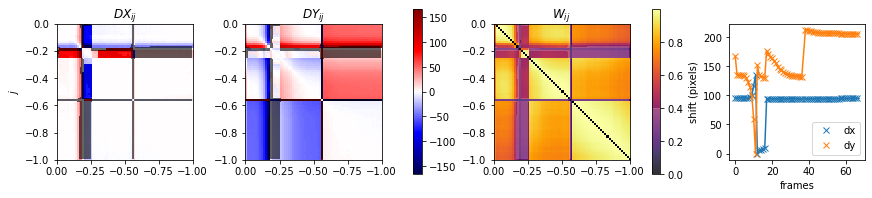

shiftshape (68, 2)


In [55]:
# Step 6 of the algorithm
w_diag = np.atleast_2d(np.diag(W))
W_n = W / np.sqrt(w_diag.T*w_diag)

# Step 7 of the algorithm
nr = np.arange(W.shape[0])*stride + startI
coords2, weightmatrix, DX, DY, row_mask = Reg.threshold_and_mask(min_norm, W, DX_DY, nr)

# Step 8 of the algorithm: reduce the shift matrix to two vectors of absolute shifts
dx, dy = Reg.calc_shift_vectors(DX, DY, weightmatrix)

# Interpolate the shifts for all values not in coords
shifts = np.stack(Reg.interp_shifts(coords2, [dx, dy], n=original.shape[0]), axis=1)
neededMargins = np.ceil(shifts.max(axis=0)).astype(int)

plot_masking(DX_DY, W_n, coords2, dx, dy, shifts, min_norm, sigma)

print("shiftshape", shifts.shape)
shifts = da.from_array(shifts, chunks=(dE, -1))

In [56]:
# Step 9, the actual shifting of the original images

# Inferring output dtype is not supported in dask yet, so we need original.dtype here.
@da.as_gufunc(signature="(i,j),(2)->(i,j)", output_dtypes=original.dtype, vectorize=True)
def shift_images(image, shift):
    """Shift `image` by `shift` pixels."""
    return ndi.shift(image, shift=shift, order=1)

padded = da.pad(original.rechunk({0: dE}),
                ((0, 0),
                 (0, neededMargins[0]),
                 (0, neededMargins[1])
                 ),
                mode='constant'
                )
corrected = shift_images(padded.rechunk({1: -1, 2: -1}), shifts)
corrected

dask.array<transpose, shape=(68, 1231, 1961), dtype=uint16, chunksize=(20, 1231, 1961), chunktype=numpy.ndarray>

In [ ]:
# Optional crop of images TODO

In [57]:
# Save as png with dask
from pyL5.lib.analysis.stack import da_imsave
os.makedirs(os.path.join(folder, subfolder), exist_ok=True)
da_imsave(os.path.join(folder, subfolder, 'image{:04d}.png'),corrected, compute=True)

In [58]:
from pyL5.solidsnakephysics.helperFunctions import save_movie
save_movie(corrected,os.path.join(folder, subfolder))

Saving stack as .png
Now saving movie stack.mp4
